In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from decimal import *

In [2]:
np.set_printoptions(threshold=sys.maxsize)

plt.rcParams["figure.figsize"] = (15,15)

# Functions

In [3]:
'''
x, y – vectors

f(x, y) – piecewise linear function
'''
def f(x, y):

    z = np.zeros_like(x)
    
    condition1 = np.logical_and(x >= 0, x >= -y)
    z[condition1] = 2*x[condition1] + y[condition1]
    
    condition2 = np.logical_and(x <= 0, x <= y)
    z[condition2] = -2*x[condition2] + y[condition2]

    condition3 = np.logical_and(x >= y, x <= -y)
    z[condition3] = -y[condition3]
    
    return z

In [4]:
'''
t – vector of points
t_k = (u_k, v_k)

p – vector of coefficients
sum(p1,...,pn) = 1

alpha > 0
'''
def f_a(x, y, t, p, alpha):
    f_a = np.zeros_like(x)
    
    for i in range(0, len(t)):
        f_a += f(x[:] - t[i, 0] * alpha, y[:] - t[i, 1] * alpha) * p[i]

    return f_a

In [13]:
'''
Calculates the value of the function
and its averaging

Returns two vectors

TODO: Dynamic x, y
'''
def calc_f(t, p, alpha):
    x = np.linspace(-1,1,100)
    y = np.linspace(-1,1,100)
    z = []

    X, Y = np.meshgrid(x, y)

    zs = np.array(f(np.ravel(X), np.ravel(Y)))
    Z = zs.reshape(X.shape)
    
    zs_a = np.array(f_a(np.ravel(X), np.ravel(Y), t, p, alpha))
    Z_a = zs_a.reshape(X.shape)
    
    return Z, Z_a

In [6]:
'''
Function for finding and comparing
minimum value of the input function
and its averaging

Returns bool value whish indicates
whether the averaging saves the extrema
'''
def find_min(Z, Z_alpha, print_result = False):
    elements, count = np.unique(Z_alpha, return_counts = True)
    duplicates = elements[count > 1]

    Z_min = Z.min()
    Z_a_min = Z_alpha.min()

    duplicate_min = np.any(duplicates == Z_a_min)
    
    if print_result:
        print('Z_min =', Z_min)
        print('Z_a_min =', Z_a_min)

        print('\nPreserves min =', not duplicate_min)
    
        print()

    return not duplicate_min

In [7]:
'''
Function for plotting the surface of the function

t – vector of points
t_k = (u_k, v_k)

p – vector of coefficients
sum(p1,...,pn) = 1

alpha > 0

is_averaging – indicator if we should plot the input function of its averaging

UTILITIES:
xy_angle – observation angle of XY plane
z_angle – observation angle of Z ax
title – title of the plot
'''
def plot_surface(t, p, alpha, is_averaging = False, xy_angle = 0, z_angle = 0, title = ''):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    ax.view_init(xy_angle, z_angle)

    x = np.linspace(0.1,0.3,100)
    y = np.linspace(-0.25,0.5,100)
    z = []

    X, Y = np.meshgrid(x, y)

    if is_averaging:
        zs = np.array(f_a(np.ravel(X), np.ravel(Y), t, p, alpha))
    else:
        zs = np.array(f(np.ravel(X), np.ravel(Y)))
        
    Z = zs.reshape(X.shape)

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.02f}')

    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.title(title)
    
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()
    
    return Z

In [8]:
'''
Function for finding and plotting the measure
of 4 points (with 1 fixed and 3 continuously changing)
where averaging of the function preserves extrema and where not

t – vector of points
t_k = (u_k, v_k)

alpha > 0
step > 0

UTILITIES:
xy_angle – observation angle of XY plane
z_angle – observation angle of Z ax


Returns two distinct vectors:
with measure that preserves extrema and where not
'''
def test_4_measures(t, alpha, step = 0.05, xy_angle = 0, z_angle = 0):
    p1 = p2 = p3 = 0.0
    p4 = 0.25
    
    p_dif = 1 - p4
    
    number_of_dec = str(step)[::-1].find('.')
    
    P = np.empty(shape=(0,4), dtype=float)
    
    P_good = np.empty(shape=(0,4), dtype=float)
    P_bad = np.empty(shape=(0,4), dtype=float)
    
    for p1 in np.arange(step, p_dif, step):
        for p2 in np.arange(step, p_dif - p1, step):
            
            p3 = p_dif - p2 - p1
            
            p1 = float(f'{p1:.{number_of_dec}f}')
            p2 = float(f'{p2:.{number_of_dec}f}')
            p3 = float(f'{p3:.{number_of_dec}f}')
            
            if p3 < step or p2 < step:
                continue
                
            p = [p1, p2, p3, p4]
               
            if any((P[:] == p).all(1)):
                continue
                
            P = np.append(P, [p], axis=0)
        
            Z_f, Z_a = calc_f(t, p, alpha)
            preserves = find_min(Z_f, Z_a)

            if preserves:
                P_good = np.append(P_good, [p], axis=0)
            else:
                P_bad = np.append(P_bad, [p], axis=0)

            if preserves:
                P_good = np.append(P_good, [p], axis=0)
            else:
                P_bad = np.append(P_bad, [p], axis=0)

    col = ['green' if any((P_good[:] == P[i,:]).all(1)) else 'red' for i in range(0, len(P))]
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(xy_angle, z_angle)
    
    ax.scatter(P[:,0], P[:,1], P[:,2], c=col)
    
    ax.set_xlabel('p1')
    ax.set_ylabel('p2')
    ax.set_zlabel('p3')
    
    #print(P)
    return P_good, P_bad

In [9]:
'''
Function for finding and plotting the measure
of 3 points that are continuously changing
where averaging of the function preserves extrema and where not

t – vector of points
t_k = (u_k, v_k)

alpha > 0
step > 0

UTILITIES:
xy_angle – observation angle of XY plane
z_angle – observation angle of Z ax


Returns two distinct vectors:
with measure that preserves extrema and where not
'''
def test_3_measures(t, alpha, step = 0.05, xy_angle = 0, z_angle = 0):
    p1 = p2 = p3 = step
    
    p_dif = 1
    
    number_of_dec = str(step)[::-1].find('.')
    
    P = np.empty(shape=(0,3), dtype=float)
    
    P_good = np.empty(shape=(0,3), dtype=float)
    P_bad = np.empty(shape=(0,3), dtype=float)
    
    for p1 in np.arange(step, p_dif, step): 
        for p2 in np.arange(step, p_dif - p1, step):
            
            p3 = p_dif - p2 - p1
            
            p1 = float(f'{p1:.{number_of_dec}f}')
            p2 = float(f'{p2:.{number_of_dec}f}')
            p3 = float(f'{p3:.{number_of_dec}f}')
            
            if p3 < step or p2 < step:
                continue
            
            p = [p1, p2, p3]
               
            if any((P[:] == p).all(1)):
                continue
                
            P = np.append(P, [p], axis=0)
        
            Z_f, Z_a = calc_f(t, p, alpha)
            preserves = find_min(Z_f, Z_a)

            if preserves:
                P_good = np.append(P_good, [p], axis=0)
            else:
                P_bad = np.append(P_bad, [p], axis=0)
            
    col = ['green' if any((P_good[:] == P[i,:]).all(1)) else 'red' for i in range(0, len(P))]
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(xy_angle, z_angle)
    
    ax.scatter(P[:,0], P[:,1], P[:,2], c=col)
    
    ax.set_xlabel('p1')
    ax.set_ylabel('p2')
    ax.set_zlabel('p3')
    
    #print(P)
    return P_good, P_bad

In [10]:
alpha = 0.5

# Tests

## Test for 4 points with custom measure

In [ ]:
t = np.array([[1,1],[1,-1],[-1,-1],[-1,1]])
p = np.array([0.4, 0.25, 0.1, 0.25])

Z, Z_a = calc_f(t, p, alpha)
preserves = find_min(Z, Z_a, True)

_ = plot_surface(t, p, alpha, is_averaging = False, xy_angle = 0, z_angle = 0)
_ = plot_surface(t, p, alpha, is_averaging = True, xy_angle = 0, z_angle = -90)

## Test for 4 points of measure with 3 continuously changing

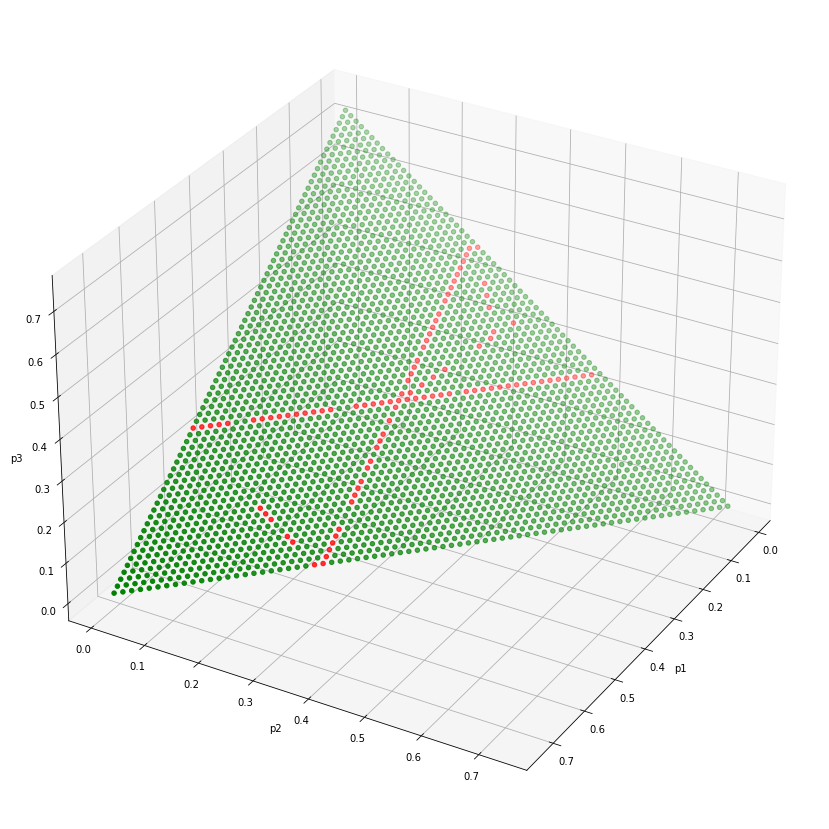

In [19]:
xy_angle = 30
z_angle = 30

step = 0.01

t1 = [1, 1]
t2 = [1, -1]
t3 = [-1, -1]
t4 = [-1, 1]

t4_set = np.array([t1, t2, t3, t4])

ps = test_4_measures(t4_set, alpha, step, xy_angle, z_angle)

## Test for 3 points of measure with 3 continuously changing

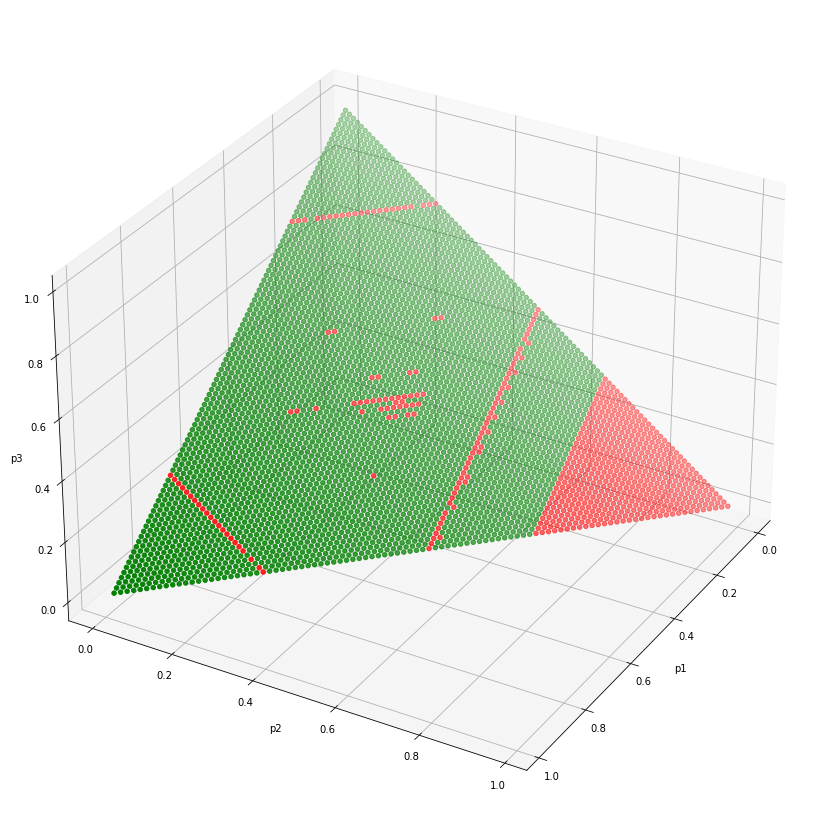

In [18]:
xy_angle = 30
z_angle = 30

step = 0.01

t1 = [1, 1]
t2 = [0, -1]
t3 = [-1, 1]

t3_set = np.array([t1, t2, t3])

p_good, p_bad = test_3_measures(t3_set, alpha, step, xy_angle, z_angle)